In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from openai import OpenAI
client = OpenAI(base_url=os.environ.get("AZURE_OPENAI_ENDPOINT"),
                api_key=os.environ.get("AZURE_OPENAI_API_KEY")
    
)

In [3]:
response = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Who is the most renowned French painter? Provide a short answer.",
        }
    ],
    model="azureai",
)
print(response.choices[0].message.content)


The most renowned French painter is widely considered to be Claude Monet, one of the founders of the Impressionist movement. His works, such as "Water Lilies" and "Impression, Sunrise," are iconic in the art world.


In [9]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [10]:
import mlflow
# Get a handle to workspace
ml_client = MLClient.from_config(credential=credential)
mlflow_tracking_uri = ml_client.workspaces.get(ml_client.workspace_name).mlflow_tracking_uri
mlflow.set_tracking_uri(mlflow_tracking_uri)

Found the config file in: .\config.json


In [11]:
class OpenAIChatModel(mlflow.pyfunc.PythonModel):

    def load_context(self, context):
        self.base_url = os.environ.get("AZURE_OPENAI_ENDPOINT")
        self.api_key = os.environ.get("AZURE_OPENAI_API_KEY")
        self.model_name = "azureai"
        

    def predict(self, context, model_input, params):

        if os.getenv("OBSERVE_WITHLANGFUSE")==True:
            from openai import OpenAI
        else:
            from langfuse.openai import OpenAI


        self.client = OpenAI(base_url=self.base_url,
                             api_key=self.api_key)
        temperature = params.get("temperature", 0) if params else 0
        response = self.client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": model_input,
                }
            ],
            model=self.model_name,
            temperature=temperature
        )
        return response.choices[0].message.content

In [ ]:
mlflow.set_experiment(f"intention_finder")

with mlflow.start_run():

    model_info = mlflow.pyfunc.log_model(
        "mistral-large-openai",
        python_model=OpenAIChatModel()
    )

loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

loaded_model.predict("How are you?")

g:\Users\Hazardeus\Documents\LLM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


"I'm just a computer program, so I don't have feelings or emotions like a human does. I'm here to help answer your questions to the best of my ability. Is there something specific you would like to know?"

Giving up execute_task_with_backoff(...) after 3 tries (httpx.ConnectError: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée)
error uploading: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée
Traceback (most recent call last):
  File "g:\Users\Hazardeus\Documents\LLM\.venv\Lib\site-packages\httpx\_transports\default.py", line 69, in map_httpcore_exceptions
    yield
  File "g:\Users\Hazardeus\Documents\LLM\.venv\Lib\site-packages\httpx\_transports\default.py", line 233, in handle_request
    resp = self._pool.handle_request(req)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "g:\Users\Hazardeus\Documents\LLM\.venv\Lib\site-packages\httpcore\_sync\connection_pool.py", line 216, in handle_request
    raise exc from None
  File "g:\Users\Hazardeus\Documents\LLM\.venv\Lib\site-packages\httpcore\_sync\connection_pool.py", line 196, in handle_request
    response = connection.handle_re

In [13]:
model_name="intention-finder"
res = mlflow.register_model(model_info.model_uri,
                      model_name)
print(res)

Registered model 'intention-finder' already exists. Creating a new version of this model...
2024/06/07 04:39:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: intention-finder, version 3


<ModelVersion: aliases=[], creation_timestamp=1717727970062, current_stage='None', description='', last_updated_timestamp=1717727970062, name='intention-finder', run_id='03cd7be5-b3d4-4c4c-a68b-41ba30fd927b', run_link='', source='azureml://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f3eb6a59-4b8a-4892-b082-d5b22c0a10ed/resourceGroups/rg-dp100-labs/providers/Microsoft.MachineLearningServices/workspaces/mlw-dp100-l/experiments/bc685233-2393-4306-aa9e-d8a9edadcc3d/runs/03cd7be5-b3d4-4c4c-a68b-41ba30fd927b/artifacts/mistral-large-openai', status='READY', status_message='', tags={}, user_id='', version='3'>


Created version '3' of model 'intention-finder'.


In [14]:
mlt_client = mlflow.tracking.MlflowClient()

mlt_client.transition_model_version_stage(
    model_name, 
    version=res.version,
    stage="Staging", 
    archive_existing_versions=True
)
mlt_client.get_latest_versions(model_name, stages=["Staging"])

C:\Users\Hazardeus\AppData\Local\Temp\ipykernel_9592\2280409893.py:3: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.2/model-registry.html#migrating-from-stages
  mlt_client.transition_model_version_stage(
C:\Users\Hazardeus\AppData\Local\Temp\ipykernel_9592\2280409893.py:9: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.2/model-registry.html#migrating-from-stages
  mlt_client.get_latest_versions(model_name, stages=["Staging"])


[<ModelVersion: aliases=[], creation_timestamp=1717021307368, current_stage='Staging', description='', last_updated_timestamp=1717243618301, name='intention-finder', run_id='b41be3c5-9a55-4436-92f3-ec329e3f8e9c', run_link='', source='azureml://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f3eb6a59-4b8a-4892-b082-d5b22c0a10ed/resourceGroups/rg-dp100-labs/providers/Microsoft.MachineLearningServices/workspaces/mlw-dp100-l/experiments/bc685233-2393-4306-aa9e-d8a9edadcc3d/runs/b41be3c5-9a55-4436-92f3-ec329e3f8e9c/artifacts/mistral-large-openai', status='READY', status_message='', tags={}, user_id='', version='2'>,
 <ModelVersion: aliases=[], creation_timestamp=1717727970062, current_stage='Staging', description='', last_updated_timestamp=1717727974232, name='intention-finder', run_id='03cd7be5-b3d4-4c4c-a68b-41ba30fd927b', run_link='', source='azureml://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f3eb6a59-4b8a-4892-b082-d5b22c0a10ed/resourceGroups/rg-dp100-labs/providers

In [15]:
model_name="intention-finder"
mlt_client = mlflow.tracking.MlflowClient()
mlt_client.get_latest_versions(model_name, stages=["Staging"])

C:\Users\fabien.iuliani\AppData\Local\Temp\ipykernel_20836\1327646972.py:3: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  mlt_client.get_latest_versions(model_name, stages=["Staging"])


[<ModelVersion: aliases=[], creation_timestamp=1716599212092, current_stage='Staging', description='', last_updated_timestamp=1717243585626, name='intention-finder', run_id='8a134e94-633d-45be-838f-d0c2b73db076', run_link='', source='azureml://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f3eb6a59-4b8a-4892-b082-d5b22c0a10ed/resourceGroups/rg-dp100-labs/providers/Microsoft.MachineLearningServices/workspaces/mlw-dp100-l/experiments/0/runs/8a134e94-633d-45be-838f-d0c2b73db076/artifacts/mistral-large-openai', status='READY', status_message='', tags={}, user_id='', version='1'>,
 <ModelVersion: aliases=[], creation_timestamp=1717021307368, current_stage='Staging', description='', last_updated_timestamp=1717243618301, name='intention-finder', run_id='b41be3c5-9a55-4436-92f3-ec329e3f8e9c', run_link='', source='azureml://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f3eb6a59-4b8a-4892-b082-d5b22c0a10ed/resourceGroups/rg-dp100-labs/providers/Microsoft.MachineLearningServices/

In [16]:
mlflow.pyfunc.load_model(f"models:/{model_name}/Staging")

C:\Users\fabien.iuliani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


mlflow.pyfunc.loaded_model:
  artifact_path: mistral-large-openai
  flavor: mlflow.pyfunc.model
  run_id: b41be3c5-9a55-4436-92f3-ec329e3f8e9c

## Model can be traced with Langfuse
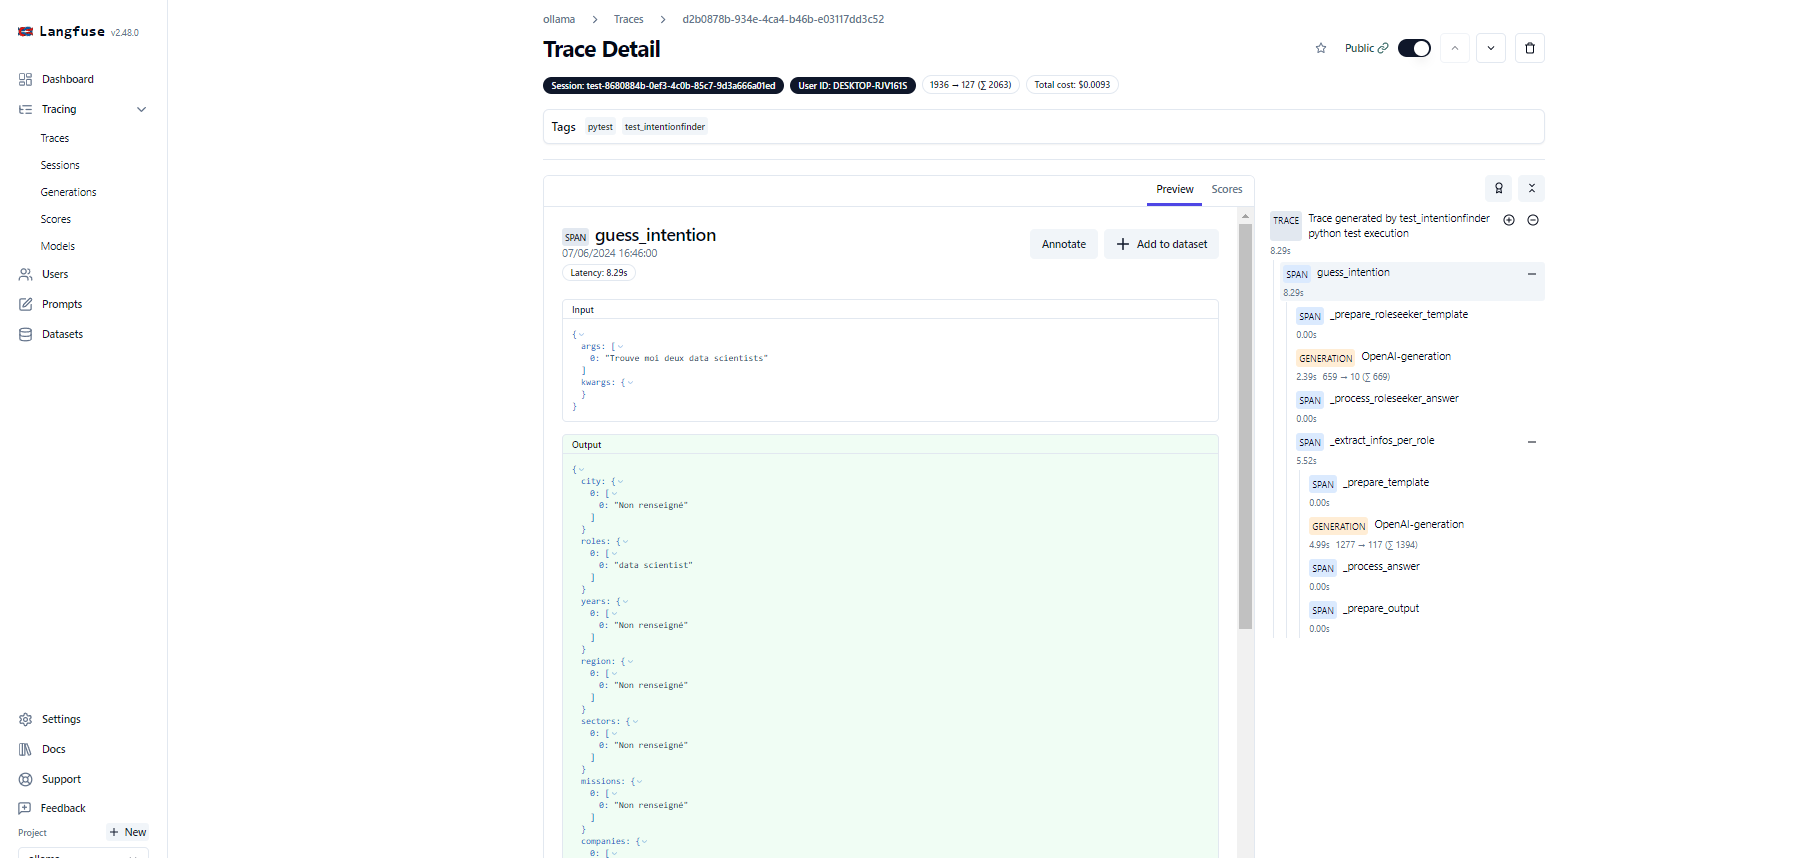